## Generating damages with CLIMADA for $R$, $R_{+}$ and $R_{-}$ areas
In this tutorial we present how to run CLIMADA to generate input damage data that then can be used in the post processing. Here, we only generate example damages for the year 2000 in Germany and Switzerland with an example flood file. Note that the demo flood file used here is only an example and does not provide reasonable damage estimates for the year 2000 in Switzerland. In order to reproduce the paper data the full ISIMIP2a ensemble needs to be run, see also the main CLIMADA tutorial on RiverFloods on how to access and treat input data: https://github.com/CLIMADA-project/climada_python/blob/develop/doc/tutorial/climada_hazard_RiverFlood.ipynb .
We strongly recommend to work through the general CLIMADA tutorial for the class RiverFlood before working through this particular application.

### Importing the required classes and packages
Before running CLIMADA you need to make sure that it is correctly installed and the conda environment is activated. See also https://climada-python.readthedocs.io/en/latest/guide/install.html for information on installation.

Importing a few useful standard packages needed:

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

If CLIMADA has been correctly installed it is possible to import the following CLIMADA packages:

In [96]:
# Required for hazard generation 
from climada.hazard.river_flood import RiverFlood
# Required for exposure generation
from climada.entity.exposures.gdp_asset import GDP2Asset
"""Loading damage functions: the residential damage functions provided in the JRC-report
   are fully implemented in CLIMADA and can be used for data reproduction"""
from climada.entity.impact_funcs.river_flood import IFRiverFlood,flood_imp_func_set

We load test files for the flooded fraction and the flood depth. These files are only the test and demo files provided with CLIMADA and cannot be used for the full reconstruction as they only cover Germany and Switzerland and do not represent the full ISIMIP2a ensemble. The global ensemble files can be downloaded from https://zenodo.org/record/4446364#.YAcVWNYo8UF  The naming convention is structured as follows:

variable_resolution_ghm_climate_forcing_protection_standard.nc

variable: relevant for damage generation are 'flddph': Flood depth and 'fldfrc' : flooded fraction

resolution: is always 150arcsec in the provided files

ghm: there are runs for 12 global hydrological models (GHMs)

climateforcing: there 4 different climate forcing datasets t
--> there are 46 combinations of GHMs and climate forcings (Supplementary Table 1)

protectionstandard: 'flopros' refers to the FLOPROS merged layer (standard procedure for main results in the article) and 'flopros-modeled' refers to the FLOPROS modeled layer

In [ ]:
from climada.util.constants import HAZ_DEMO_FLDDPH, HAZ_DEMO_FLDFRC

We load test files for exposure generation. This file used here is only the test and demo filesprovided with CLIMADA and cannot be used for the full reconstruction as it only covers Switzerland for the year 2000. The full exposure file can be downloaded also from  http://doi.org/10.5281/zenodo.4446364 --> gdp_1850_2100_150arcsec.nc

In [ ]:
from climada.util.constants import DEMO_GDP2ASSET

The original file on gridded GDP includes a SSP transition for the period 2000-2010 where we move from the observational period to the SSP2 scenario. The annual rescaling factors that allow to eliminate the SSP transition and get pure observation based GDP until 2010. Exposure needs to be rescaled by means of the annual national conversion factor. This file is needed for data reconstruction:

In [107]:
ssp_resc = pd.read_csv('../../../data/exposure_rescaling/totalwealth_capital_stock_rescaling.csv')


The CLIMADA exposure output generated here provides asset information basing on the total national wealth indicator. Here, we translate this asset indicator into capital stock applying an annual national ratio of GDP to capital stock given in the following file (needed for data reconstruction):

In [108]:
## conversion factors to translate total national wealth into capital stock
cap_stock_conv = pd.read_csv('../../../data/exposure_rescaling/resc_ssp_transition.csv')

Note that the files totalwealth_capital_stock_rescaling.csv and resc_ssp_transition.csv can be reproduced with the scripts in folder /code/scripts_reconstruction/ starting with 
exp_rescaling.py .

The following file indicates whether the general discharge trend within a given river basin has been positive or negative and is needed to isolate the $R_{+}$ subregion from the $R_{-}$ subregion of a country. The file is provided in the indicated folder and can be used for reproduction. The file can either be used directly from the /data/hazard_settings folder or genrated with the data on discharge provided by ISIMIP and the scripts given in the folder '/code/scripts_reconstruction/basin_trend_assessment' starting with dis_trend_estimation.py :

In [38]:
basin_trend_file = '../../../data/hazard_settings/basin_trends.nc'

The file provided here, allows to exclude areas that are flooded every 2 years or more often from damage assessment, as it can be assumed that nobody builds assets in these areas. The file should be used for damage reconstruction:

In [ ]:
frc_2yr_return_level = '../../../data/hazard_settings/fldfrc_2yr_return_level.nc'

### Flood hazard for the year 2000 in Germany

2021-01-13 23:55:01,877 - climada.util.coordinates - INFO - Reading /home/insauer/Climada/climada_python/data/demo/flddph_WaterGAP2_miroc5_historical_flopros_gev_picontrol_2000_0.1.nc
2021-01-13 23:55:02,348 - climada.util.coordinates - INFO - Reading /home/insauer/Climada/climada_python/data/demo/fldfrc_WaterGAP2_miroc5_historical_flopros_gev_picontrol_2000_0.1.nc


/home/insauer/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/home/insauer/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


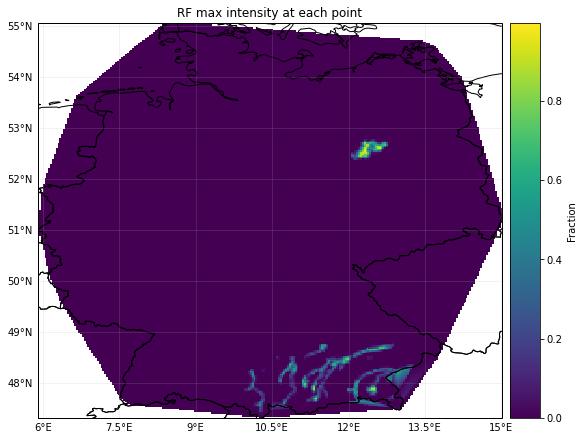

In [98]:
# We here only generate data for the year 2000
years = [2000]
# generating RiverFlood hazard from netCDF file
# uses centroids from ISIMIP for Germany
"""when working with the real files insert a path for the 'flddph....nc' after dph_path
   and the path for the 'fldfrc..' with the same settings (resolution, ghm...) for frc_path"""
rf = RiverFlood()
rf.set_from_nc(countries = ['DEU'], years=years, dph_path=HAZ_DEMO_FLDDPH, frc_path=HAZ_DEMO_FLDFRC,
               ISINatIDGrid=True)
rf.plot_fraction(0)

### Flood hazard after the areas flooded with a two year period are discounted
The fractions that are flooded at least every two years are now discounted in the following step (flooded fraction is set to zero there):

In [99]:
rf.exclude_returnlevel(frc_2yr_return_level)

2021-01-13 23:57:37,141 - climada.util.coordinates - INFO - Reading /home/insauer/projects/NC_Submission/Data/damage_generation/fldfrc_2yr_return_level.nc


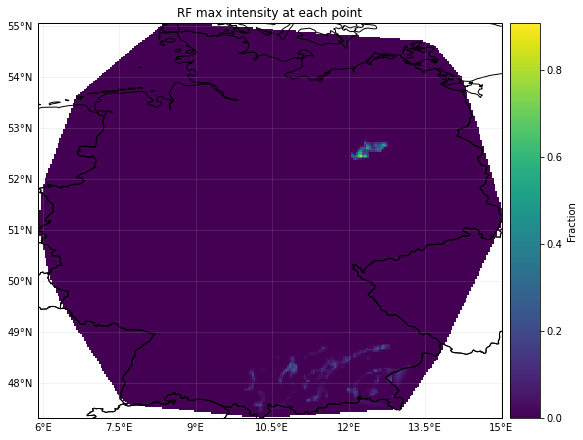

In [100]:
rf.plot_fraction(0)

### Calculating damage for $R$, $R_{+}$ and $R_{-}$ areas in Switzerland

2021-01-14 00:05:50,097 - climada.util.coordinates - INFO - Reading /home/insauer/Climada/climada_python/data/demo/flddph_WaterGAP2_miroc5_historical_flopros_gev_picontrol_2000_0.1.nc
2021-01-14 00:05:50,568 - climada.util.coordinates - INFO - Reading /home/insauer/Climada/climada_python/data/demo/fldfrc_WaterGAP2_miroc5_historical_flopros_gev_picontrol_2000_0.1.nc


/home/insauer/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


/home/insauer/anaconda3/envs/climada_env/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


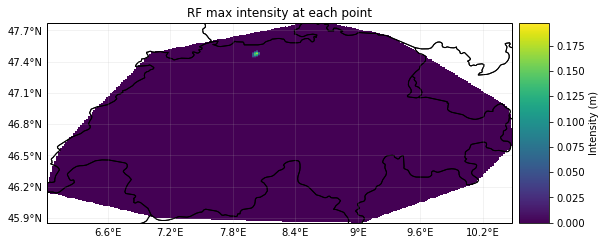

In [112]:
rf = RiverFlood()
rf.set_from_nc(countries = ['CHE'], years=years, dph_path=HAZ_DEMO_FLDDPH, frc_path=HAZ_DEMO_FLDFRC,
               ISINatIDGrid=True)
rf.plot_intensity(0)

2021-01-14 00:06:02,446 - climada.util.coordinates - INFO - Reading /home/insauer/projects/NC_Submission/Data/damage_generation/basin_trends.nc


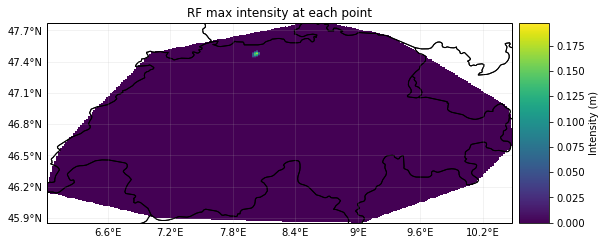

In [113]:
rf_pos = copy.copy(rf)
rf_pos.exclude_trends(basin_trend_file, 'pos')
rf_pos.plot_intensity(0)

2021-01-14 00:06:06,128 - climada.util.coordinates - INFO - Reading /home/insauer/projects/NC_Submission/Data/damage_generation/basin_trends.nc


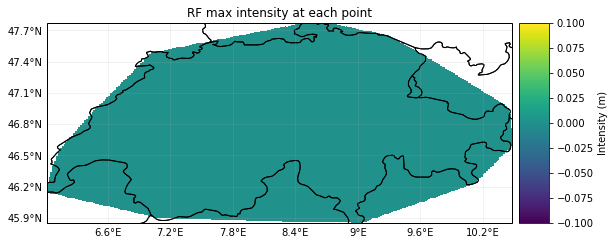

In [114]:
rf_neg = copy.copy(rf)
rf_neg.exclude_trends(basin_trend_file, 'neg')
rf_neg.plot_intensity(0)

In order to get only the $R_{+}$ or $R_{-}$ damage of one country the hazard is masked (set to zero) in the area that is not considered. In Switzerland apparently all basins show a positive discharge trend, so that the intensity is now zero everywhere in $R_{-}$

### Exposure generation

To set exposures for all countries and years, download the file "gdp_1850_2100_150arcsec.nc" here  http://doi.org/10.5281/zenodo.4446364 and replace DEMO_GDP2ASSET with the file path.

In [120]:
gdpa = GDP2Asset()
gdpa.set_countries(countries = ['CHE'], ref_year = 2000, path=DEMO_GDP2ASSET)
# get rescaling factor to eliminate SSP for 2000 in Switzerland
ssp_resc_che  = ssp_resc.loc[ssp_resc['ISO'] == 'CHE', str(2000)].values[0]
# get rescaling factor to convert from total wealth to capital stock
cap_stock_conv_che = cap_stock_conv.loc[cap_stock_conv['ISO'] == 'CHE', str(2000)].values[0]
# convert exposure value
gdpa['value'] = gdpa['value'] * ssp_resc_che * cap_stock_conv_che
gdpa

,value,latitude,longitude,if_RF,region_id
0,2.461288e+09,45.853916,8.937364,3.0,11.0
1,1.661448e+09,45.853916,8.979031,3.0,11.0
2,1.557125e+08,45.853916,9.020698,3.0,11.0
3,2.034196e+08,45.895583,7.104034,3.0,11.0
4,2.405581e+08,45.895583,7.145701,3.0,11.0
...,...,...,...,...,...
2755,1.339595e+08,47.770580,8.520698,3.0,11.0
2756,1.152239e+08,47.770580,8.562365,3.0,11.0
2757,1.559944e+08,47.770580,8.604032,3.0,11.0
2758,2.842522e+08,47.770580,8.645698,3.0,11.0


Set the damage function for Europe (the correct id is given for each country automatically in the exposure setting (if_RF), so only flood_imp_func_set() needs to be loaded)

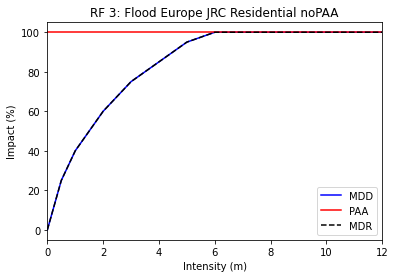

In [122]:
if_set = flood_imp_func_set()
if_CHE = if_set.get_func(fun_id=3)
if_CHE[0].plot()

### Calculating damage for $R$

In [117]:
from climada.engine import Impact

imp=Impact()
imp.calc(gdpa, if_set,rf)
imp.at_event[0]

2021-01-14 00:06:17,492 - climada.entity.exposures.base - INFO - Matching 2760 exposures with 2760 centroids.
2021-01-14 00:06:17,499 - climada.engine.impact - INFO - Calculating damage for 2577 assets (>0) and 1 events.


156975.48252710348

### Calculating damage for $R_{+}$

In [118]:
imp_pos=Impact()
imp_pos.calc(gdpa, if_set,rf_pos)
imp_pos.at_event[0]

2021-01-14 00:06:23,539 - climada.engine.impact - INFO - Exposures matching centroids found in centr_RF
2021-01-14 00:06:23,544 - climada.engine.impact - INFO - Calculating damage for 2577 assets (>0) and 1 events.


156975.48252710348

### Calculating damage for $R_{-}$

In [119]:
imp_neg=Impact()
imp_neg.calc(gdpa, if_set,rf_neg)
imp_neg.at_event[0]

2021-01-14 00:06:27,427 - climada.engine.impact - INFO - Exposures matching centroids found in centr_RF
2021-01-14 00:06:27,434 - climada.engine.impact - INFO - Calculating damage for 2577 assets (>0) and 1 events.


0.0

For the generation of the entire global damage set, see ..../code/scripts_reconstruction/run_climada/schedule_sim.py. Note that damages need to be calculated on the country level and are then aggregated to the region level, as described in demo_data_aggregation.ipynb and for full reconstruction in .../code/scripts_reconstruction/postprocessing/data_aggregation_regions.py and data_aggregation_subregions.py